In [1]:
import numpy as np
import random

In [34]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):  # 生成一个下标不同的alpha
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

# SVM知识解析

要看的懂下面的算法需要对SVM有足够的认知，首先我们要了解我们的决策函数:

$$f(x) = sign \left ( \sum^N_{i=1}a_i^*y_iK(x\cdot x_i ) + b^* \right ) $$

其中K(x * xi)为核函数，如果是线性可分数据集那么可以分解为$x \cdot xi$，下面的算法使用的就是线性可分数据集，所以可以使用矩阵乘法简化运算。

SMO算法的大致思想是如果要对目标函数进行优化，那么就需要保证目标函数满足拉格朗日对偶条件即KKT，所以有$0 < a_i < C$。其中C是对于$a_i$的限制，保证其不会过大。

求解算法详情见李航的《统计学习方法》。

下面算法的流程大致如下:

然后要给定迭代次数，通过迭代使alpha收敛。
如果所有的变量都满足此最优化问题的KKT条件，那么这个最优化问题的解就找到了，因为KKT条件是该最优化问题的充分必要条件。否则选择两个变量，固定其他变量，针对这两个变量构建一个二次规划问题，这个二次规划问题的解会更接近于原始二次规划问题。

那么这两个变量应该如何找到呢，对于第一个变量我们称其为外层变量，这个变量在下面的算法中通过循环给定，所以违反KKT条件最为严重，第二个变量由约束条件计算得出，由于等式约束可知:
$$a_1 = -y_1\sum^N_{i=2}a_iy_i$$
如果第二个变量确定那么a1也随之确定，所以子问题同时更新两个变量。

外层循环找到第一个变量，计算当前预测值与真实值的误差，若超过给定的阈值那么需要更新此值，但是更新计算需要两个变量，所以从alpha中随机选择一个作为第二变量（两个变量不能相同)，然后根据线性规划我们确定a2最优值所在的区间:

![](https://images2015.cnblogs.com/blog/1042406/201611/1042406-20161128221540099-1580490663.png)

设置线段在a2方向上的投影为a2的最优值，但是这条线段平行于对角线，所以最优值处于一个区间之中，下限坐标是Max(0，a2-a1)，上限坐标是Min(C,C+a2-a1)。

当确定a2的取值范围L和H之后，就要计算$\eta$了，这个是根据公式得到的，详情见李航原书:
$$a_2^{new,unc} = a_2^{old} + y_2\frac{(E_1 - E_2)}{\eta}$$

E1和E2是计算值与预测值的偏差，由公式可以计算出未剪辑的a2，之所以未剪辑是因为没有加上我们算出的a2必须处于(L，H)区间这个条件。

$$a_2^{new} = \left\{\begin{matrix}
H & a_2^{new, unc}  > H \\ 
a_2^{new, unc}  & L \leq a_2^{new, unc} \leq H  \\ 
L &  a_2^{new, unc} < L \\
\end{matrix}\right.$$

然后我们就算出了a2的优化值，然后根据公式由a2计算a1:
$$a_1^{new} = a_1^{old} + y_1 y_2(a_2^{old} - a_2^{new})$$

算出a1和a2之后我们就要重新计算阈值b,但是现在有两个变量a1和a2，我们分别通过a1与a2计算b1和b2。

$$b_1^{new} = -E_1 - y_1 K_{11}(a_1^{new} - a_1^{old}) - y_2 K_{21}(a_2^{new} - a_2^{old}) + b^{old}$$
$$b_2^{new} = -E_2 - y_1 K_{12}(a_1^{new} - a_1^{old}) - y_2 K_{22}(a_2^{new} - a_2^{old}) + b^{old}$$

然后我们要根据a1与a2是否满足KKT条件来选择b1与b2，如果a1与a2都满足KKT条件，那么b1=b2;如果a1或a2是0或者c，那么此时他们之间的数是满足KKT条件的，选择他们的中点作为$b^{new}$。

最后计算出alpha不等于０的样本，就是支持向量。

In [35]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    b = 0; m,n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        
        """
        SMO在训练样本中选取违反KKT条件最严重的样本，将其作为第一个变量
        """
        
        for i in range(m):
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b # 决策函数的向量化
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            
            """
            # 如果误差大则进行优化，进入内层循环找到第二个变量
            此处要保证alpha不能等于０或者C，这代表他们已经在边界上无法继续进行优化了。
            """
            
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):  
                
                j = selectJrand(i,m)  # 随机选择第二个变量，第二个变量的选择标准
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                
                if (labelMat[i] != labelMat[j]):  # 此处SMO中为y1与y2判断L和H，符号不同则L和H也不同
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                    
                if L==H: 
                    print ("L==H") 
                    continue
                
                # 此处为公式中的eta
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                
                if eta >= 0: 
                    print ("eta>=0")
                    continue
                
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta  # a2的未剪辑解
                
                alphas[j] = clipAlpha(alphas[j],H,L)  # 获取剪辑后的解
                
                if (abs(alphas[j] - alphaJold) < 0.00001):   # a2没有足够大的变化
                    print ("j not moving enough") 
                    continue
                
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                
                """
                如果a1_new和a2_new同时满足KKT条件，那么b1=b2
                否则选择满足KKT条件的解
                若都不满足则取平均值
                """
                
                if (0 < alphas[i]) and (C > alphas[i]):  
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): 
                    b = b2
                else: 
                    b = (b1 + b2)/2.0
                
                alphaPairsChanged += 1
                
                print ("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): 
            iter += 1
        else: 
            iter = 0
        print ("iteration number: %d" % iter)
    return b,alphas

In [36]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

iter: 0 i:0, pairs changed 1
L==H
j not moving enough
iter: 0 i:8, pairs changed 2
L==H
L==H
j not moving enough
L==H
L==H
L==H
iter: 0 i:29, pairs changed 3
iter: 0 i:31, pairs changed 4
iter: 0 i:34, pairs changed 5
j not moving enough
L==H
j not moving enough
iter: 0 i:54, pairs changed 6
iter: 0 i:55, pairs changed 7
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
iter: 0 i:31, pairs changed 1
j not moving enough
iter: 0 i:46, pairs changed 2
iter: 0 i:49, pairs changed 3
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iteration number: 0
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
iteration number: 2
j not moving enough
iter: 2 i:8, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 13
j not moving enough
j not moving enough
iter: 13 i:54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
iter: 1 i:29, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
iter: 1 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not

iteration number: 5
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
iter: 8 i:55, pairs changed 1
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
iter: 7 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
iter: 0 i:29, pairs changed 1
j not moving enough
j not movi

iteration number: 27
j not moving enough
j not moving enough
iteration number: 28
j not moving enough
j not moving enough
iteration number: 29
j not moving enough
j not moving enough
iteration number: 30
j not moving enough
j not moving enough
iteration number: 31
j not moving enough
j not moving enough
iteration number: 32
j not moving enough
j not moving enough
iteration number: 33
j not moving enough
j not moving enough
iteration number: 34
j not moving enough
j not moving enough
iteration number: 35
j not moving enough
j not moving enough
iteration number: 36
j not moving enough
j not moving enough
iteration number: 37
j not moving enough
j not moving enough
iteration number: 38
j not moving enough
j not moving enough
iteration number: 39
j not moving enough
j not moving enough
iteration number: 40


In [37]:
def plotBestFit(alphas, b, dataMat, labelMat):
    import matplotlib.pyplot as plt
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0]
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i]) > 0:
            xcord1.append(dataArr[i, 0])
            ycord1.append(dataArr[i, 1])
        else:
            xcord2.append(dataArr[i, 0])
            ycord2.append(dataArr[i, 1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    weights = get_weights(alphas, dataMat, labelMat)
    x = np.arange(--2, 8, 0.1)  # 生成-3到3的数组
    b = np.array(b)
    y = (-b[0][0]- weights[0][0] * x) / weights[0][1]  # 此处计算 0 = b + w1 * x + w2 * y
    ax.plot(x,y)                                      # numpy的除号对于矩阵来说是对应元素相除
    plt.show()
    
def get_weights(alpha,  data, label):
    weights = np.zeros((1, len(data[0])))
    for i in range(len(alpha)):
        weights += alpha[i] * data[i] * label[i]
    return weights

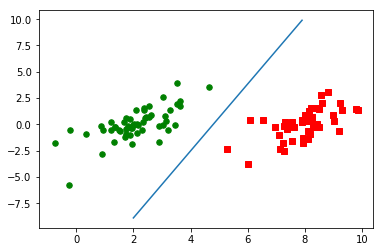

In [38]:
dataArr, labelArr = loadDataSet('testSet.txt')

plotBestFit(alphas, b, dataArr, labelArr)

# 此处只有支持向量起作用，所以权重不能从１开始，因为支持向量机对权重的变化敏感(只有支持向量对超平面产生影响)。

# 　完整版SMO算法

SMO在选择第二个变量时，使用了启发式。假设在外层循环中已经找到了第一个变量$a_1$,现在要在内层循环中找到第二个变量$a_2$，第二个变量选择的标准是希望能使$a_2$有足够大的变化。由上面的公式可以得a2的选择与|E2-E1|是存在关系的，为了加快计算a2，一种简单的做法是选择a2,使其对应的|E2-E1|最大，因为a1已定，E1已经确定下来了，如果E1是正的就取最小的Ei作为E2，如果E1是负的，就取最大的Ei作为E2，为了节省时间就把所有的Ei值保存在一个列表中。

在特殊情况下，如果内层循环通过以上的方法选择的a2不能使目标函数有足够的下降，那么采用以下启发式规则继续选择a2,遍历在间隔边界上的支持向量点，依次将其对应的变量作为a2试用，直到目标函数有足够的下降，若找不到合适的a2,那么遍历训练数据集，若仍找不到合适的a2,则放弃第一个a1,再通过外层循环找到另外的a1.

In [21]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) #first column is valid flag

def selectJ(i, oS, Ei):   # 内循环，计算|Ei - Ek|并找到最大偏移的第二变量
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]  # .A代表将矩阵转换为数组类型
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: 
                continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:   # in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)  # 随机选择一个aj，并计算Ej
        Ej = calcEk(oS, j)
    return j, Ej

def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

def innerL(i, oS):
    Ei = calcEk(oS, i)
    
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: 
            print ("L==H")
            return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        
        if eta >= 0: 
            print ("eta>=0")
            return 0
        
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        
        updateEk(oS, j) #added this for the Ecache
        
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            print ("j not moving enough")
            return 0
        
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): 
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else: 
            oS.b = (b1 + b2)/2.0
        return 1
    else: 
        return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter):    #full Platt SMO
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0  # 获取当前的alpha的偏移量也就是目标函数的下降值，用来判断内循环时是否存在合适的a2
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        
        """
        第一次遍历时，由于不存在支持向量点，所以对整个数据集进行计算，找到满足条件alpha
        然后对当前满足条件的间隔边界的支持向量点进行计算直到目标函数有足够的下降
        若找不到合适的a2导致下降度不够而且当前迭代次数小于最大迭代次数，那么遍历训练数据集更新alpha
        再次对间隔边界的支持向量点进行计算
        以此类推直到满足最大迭代次数
        """
        
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print ("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print ("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: 
            entireSet = False # toggle entire set loop
        elif (alphaPairsChanged == 0): 
            entireSet = True  
        print ("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [22]:
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 2
fullSet, iter: 0 i:4, pairs changed 3
fullSet, iter: 0 i:5, pairs changed 4
fullSet, iter: 0 i:6, pairs changed 4
fullSet, iter: 0 i:7, pairs changed 4
j not moving enough
fullSet, iter: 0 i:8, pairs changed 4
fullSet, iter: 0 i:9, pairs changed 4
j not moving enough
fullSet, iter: 0 i:10, pairs changed 4
fullSet, iter: 0 i:11, pairs changed 4
fullSet, iter: 0 i:12, pairs changed 4
fullSet, iter: 0 i:13, pairs changed 4
fullSet, iter: 0 i:14, pairs changed 4
fullSet, iter: 0 i:15, pairs changed 4
fullSet, iter: 0 i:16, pairs changed 4
j not moving enough
fullSet, iter: 0 i:17, pairs changed 4
fullSet, iter: 0 i:18, pairs changed 4
fullSet, iter: 0 i:19, pairs changed 4
fullSet, iter: 0 i:20, pairs changed 4
fullSet, iter: 0 i:21, pairs changed 4
fullSet, iter: 0 i:22, pairs changed 4
j not moving enough
fullSet, iter: 0 i:23, pairs chan

In [23]:
get_weights(alphas, dataArr, labelArr)

array([[ 0.75326754, -0.15699763]])

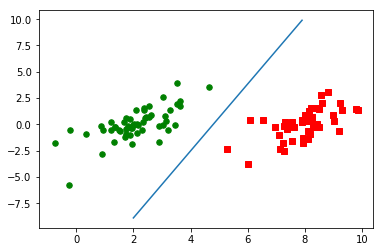

In [39]:
dataArr, labelArr = loadDataSet('testSet.txt')

plotBestFit(alphas, b, dataArr, labelArr)

# 核函数版

原始数据经过映射为高维空间的数据可以把非线性问题转换成线性问题,但是问题是这样会带来复杂的计算
我们通过核函数可以避免高维度的复杂计算
高斯核公式如下:
$$K(x,z) = exp\left ( -\frac{\left \| x-z \right \|^2}{2\sigma ^2 } \right )$$
高斯核可以把数据映射到无穷维。

其中下面算法中的K为输入空间对应的Gram矩阵(内积空间)，kTup代表当前是否启动高斯核函数，kTup第一个参数是当前的类型，第二个参数是如果使用高斯核那么$\sigma$的值。

Gram矩阵可以简化内积的运算，其中每个元素的值都是对应坐标的内积，对于$x_i \cdot z_j$ 就可以直接简化为$G_{ij}$。

$$ G = \begin{bmatrix} x_i \cdot z_j \end{bmatrix}_{M \times  N} $$

对于普通的向量$X$，如果求其Gram矩阵，直接让$X \times X^T$即可。

对于核函数的Gram矩阵，不能直接进行向量乘法，要经过处理，比如对于$X, Z$的高斯核Gram矩阵，其$G_{ij}$的算法如下:
$$G_{ij} = exp\left ( -\frac{ (x_i - z_j) \times  (x_i - z_j)^T  }{2\sigma ^2 } \right ) $$

此时$x_i \times z_j$在低维空间的内积就转换成高维空间的$G_{ij}$。

对于$X \times X$，如果此时需要计算$X \times x_i$，那么可以直接用列向量$G_{kj}, k=1,2,3 \cdots n$表示。

In [25]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) #first column is valid flag
        self.K = np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):  # 计算Gram矩阵
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

def selectJ(i, oS, Ei):   # 内循环，计算|Ei - Ek|并找到最大偏移的第二变量
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]  # .A代表将矩阵转换为数组类型
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: 
                continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:   # in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)  # 随机选择一个aj，并计算Ej
        Ej = calcEk(oS, j)
    return j, Ej

def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

def kernelTrans(X, A, kTup):  # 返回Gram的列向量
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0]=='lin': 
        K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':  # 高斯核
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T  # 两个向量的距离为点积
        K = np.exp(K/(-1*kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
    else: 
        raise NameError('Houston We Have a Problem -That Kernel is not recognized')
    return K
        
def calcEk(oS, k):
    
    """
    计算公式中的 X * xi
    """
    
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: 
            print ("L==H")
            return 0
        
        """
        此处eta的计算被Gram矩阵简化了
        os.K[i,j] = os.X[i,:] * os.X[j, :].T
        """
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        
        if eta >= 0: 
            print ("eta>=0")
            return 0
        
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        
        updateEk(oS, j) #added this for the Ecache
        
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            print ("j not moving enough")
            return 0
        
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): 
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else: 
            oS.b = (b1 + b2)/2.0
        return 1
    else: 
        return 0

    
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0  # 获取当前的alpha的偏移量也就是目标函数的下降值，用来判断内循环时是否存在合适的a2
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        
        """
        第一次遍历时，由于不存在支持向量点，所以对整个数据集进行计算，找到满足条件alpha
        然后对当前满足条件的间隔边界的支持向量点进行计算直到目标函数有足够的下降
        若找不到合适的a2导致下降度不够而且当前迭代次数小于最大迭代次数，那么遍历训练数据集更新alpha
        再次对间隔边界的支持向量点进行计算
        以此类推直到满足最大迭代次数
        """
        
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print ("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print ("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: 
            entireSet = False # toggle entire set loop
        elif (alphaPairsChanged == 0): 
            entireSet = True  
        print ("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [60]:
import numpy as np

def calcWs(alphas,dataArr,classLabels):
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

def testRbf(k1=1.3):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')
    
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    
    datMat=np.mat(dataArr);
    labelMat = np.mat(labelArr).transpose()
    
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #获取支持向量矩阵
    labelSV = labelMat[svInd];  # 支持向量对应的标签
    print ("there are %d Support Vectors" % np.shape(sVs)[0])
    print(labelSV.shape, alphas[svInd].shape)
    m,n =np. shape(datMat)
    errorCount = 0
    
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))  # 计算内积即X * xi，此处只计算支持向量矩阵与样本的内积
        predict=kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b  #带入模型计算预测值  np.multiply对应元素相乘求点积
        if np.sign(predict)!=np.sign(labelArr[i]):  # 与预期值进行对比
            errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))

    dataArr,labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat=np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): 
            errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m) )   

In [61]:
testRbf()

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 3
fullSet, iter: 0 i:5, pairs changed 4
fullSet, iter: 0 i:6, pairs changed 4
j not moving enough
fullSet, iter: 0 i:7, pairs changed 4
fullSet, iter: 0 i:8, pairs changed 4
j not moving enough
fullSet, iter: 0 i:9, pairs changed 4
fullSet, iter: 0 i:10, pairs changed 5
fullSet, iter: 0 i:11, pairs changed 5
fullSet, iter: 0 i:12, pairs changed 5
fullSet, iter: 0 i:13, pairs changed 6
L==H
fullSet, iter: 0 i:14, pairs changed 6
fullSet, iter: 0 i:15, pairs changed 7
fullSet, iter: 0 i:16, pairs changed 8
fullSet, iter: 0 i:17, pairs changed 9
fullSet, iter: 0 i:18, pairs changed 9
fullSet, iter: 0 i:19, pairs changed 9
fullSet, iter: 0 i:20, pairs changed 9
fullSet, iter: 0 i:21, pairs changed 10
j not moving enough
fullSet, iter: 0 i:22, pairs changed 10
j not moving enough
fullSet, iter: 0 i:23, pai

j not moving enough
fullSet, iter: 3 i:51, pairs changed 0
j not moving enough
fullSet, iter: 3 i:52, pairs changed 0
fullSet, iter: 3 i:53, pairs changed 0
j not moving enough
fullSet, iter: 3 i:54, pairs changed 0
j not moving enough
fullSet, iter: 3 i:55, pairs changed 0
j not moving enough
fullSet, iter: 3 i:56, pairs changed 0
fullSet, iter: 3 i:57, pairs changed 0
fullSet, iter: 3 i:58, pairs changed 0
fullSet, iter: 3 i:59, pairs changed 0
j not moving enough
fullSet, iter: 3 i:60, pairs changed 0
j not moving enough
fullSet, iter: 3 i:61, pairs changed 0
j not moving enough
fullSet, iter: 3 i:62, pairs changed 0
fullSet, iter: 3 i:63, pairs changed 0
j not moving enough
fullSet, iter: 3 i:64, pairs changed 0
fullSet, iter: 3 i:65, pairs changed 0
fullSet, iter: 3 i:66, pairs changed 0
fullSet, iter: 3 i:67, pairs changed 0
j not moving enough
fullSet, iter: 3 i:68, pairs changed 0
fullSet, iter: 3 i:69, pairs changed 0
fullSet, iter: 3 i:70, pairs changed 0
j not moving enough


In [66]:
def img2vector(filename):
    returnVect = np.zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: 
            hwLabels.append(-1)
        else: 
            hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels    

def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print( "there are %d Support Vectors" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): 
            errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat=np.mat(dataArr)
    labelMat =np. mat(labelArr).transpose()
    m,n =np. shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): 
            errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m) )


In [67]:
testDigits()

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 2
fullSet, iter: 0 i:2, pairs changed 3
fullSet, iter: 0 i:3, pairs changed 4
fullSet, iter: 0 i:4, pairs changed 5
fullSet, iter: 0 i:5, pairs changed 6
fullSet, iter: 0 i:6, pairs changed 7
fullSet, iter: 0 i:7, pairs changed 8
fullSet, iter: 0 i:8, pairs changed 9
fullSet, iter: 0 i:9, pairs changed 10
fullSet, iter: 0 i:10, pairs changed 11
fullSet, iter: 0 i:11, pairs changed 12
fullSet, iter: 0 i:12, pairs changed 13
fullSet, iter: 0 i:13, pairs changed 14
fullSet, iter: 0 i:14, pairs changed 15
fullSet, iter: 0 i:15, pairs changed 16
fullSet, iter: 0 i:16, pairs changed 17
fullSet, iter: 0 i:17, pairs changed 18
fullSet, iter: 0 i:18, pairs changed 19
fullSet, iter: 0 i:19, pairs changed 20
fullSet, iter: 0 i:20, pairs changed 21
fullSet, iter: 0 i:21, pairs changed 22
fullSet, iter: 0 i:22, pairs changed 23
fullSet, iter: 0 i:23, pairs changed 24
fullSet, iter: 0 i:24, pairs changed 25
fullSet, iter: 0 i:

j not moving enough
fullSet, iter: 0 i:196, pairs changed 107
L==H
fullSet, iter: 0 i:197, pairs changed 107
fullSet, iter: 0 i:198, pairs changed 107
fullSet, iter: 0 i:199, pairs changed 107
fullSet, iter: 0 i:200, pairs changed 107
j not moving enough
fullSet, iter: 0 i:201, pairs changed 107
L==H
fullSet, iter: 0 i:202, pairs changed 107
j not moving enough
fullSet, iter: 0 i:203, pairs changed 107
L==H
fullSet, iter: 0 i:204, pairs changed 107
L==H
fullSet, iter: 0 i:205, pairs changed 107
L==H
fullSet, iter: 0 i:206, pairs changed 107
fullSet, iter: 0 i:207, pairs changed 107
fullSet, iter: 0 i:208, pairs changed 107
L==H
fullSet, iter: 0 i:209, pairs changed 107
L==H
fullSet, iter: 0 i:210, pairs changed 107
L==H
fullSet, iter: 0 i:211, pairs changed 107
L==H
fullSet, iter: 0 i:212, pairs changed 107
L==H
fullSet, iter: 0 i:213, pairs changed 107
fullSet, iter: 0 i:214, pairs changed 107
L==H
fullSet, iter: 0 i:215, pairs changed 107
L==H
fullSet, iter: 0 i:216, pairs changed 10

j not moving enough
non-bound, iter: 1 i:2, pairs changed 0
j not moving enough
non-bound, iter: 1 i:3, pairs changed 0
j not moving enough
non-bound, iter: 1 i:4, pairs changed 0
j not moving enough
non-bound, iter: 1 i:5, pairs changed 0
j not moving enough
non-bound, iter: 1 i:6, pairs changed 0
j not moving enough
non-bound, iter: 1 i:7, pairs changed 0
j not moving enough
non-bound, iter: 1 i:8, pairs changed 0
j not moving enough
non-bound, iter: 1 i:9, pairs changed 0
j not moving enough
non-bound, iter: 1 i:11, pairs changed 0
j not moving enough
non-bound, iter: 1 i:15, pairs changed 0
j not moving enough
non-bound, iter: 1 i:16, pairs changed 0
j not moving enough
non-bound, iter: 1 i:18, pairs changed 0
j not moving enough
non-bound, iter: 1 i:21, pairs changed 0
j not moving enough
non-bound, iter: 1 i:22, pairs changed 0
j not moving enough
non-bound, iter: 1 i:23, pairs changed 0
j not moving enough
non-bound, iter: 1 i:24, pairs changed 0
j not moving enough
non-bound, i

j not moving enough
fullSet, iter: 2 i:26, pairs changed 0
j not moving enough
fullSet, iter: 2 i:27, pairs changed 0
j not moving enough
fullSet, iter: 2 i:28, pairs changed 0
j not moving enough
fullSet, iter: 2 i:29, pairs changed 0
fullSet, iter: 2 i:30, pairs changed 0
j not moving enough
fullSet, iter: 2 i:31, pairs changed 0
j not moving enough
fullSet, iter: 2 i:32, pairs changed 0
fullSet, iter: 2 i:33, pairs changed 0
j not moving enough
fullSet, iter: 2 i:34, pairs changed 0
j not moving enough
fullSet, iter: 2 i:35, pairs changed 0
fullSet, iter: 2 i:36, pairs changed 0
j not moving enough
fullSet, iter: 2 i:37, pairs changed 0
fullSet, iter: 2 i:38, pairs changed 0
fullSet, iter: 2 i:39, pairs changed 0
fullSet, iter: 2 i:40, pairs changed 0
j not moving enough
fullSet, iter: 2 i:41, pairs changed 0
j not moving enough
fullSet, iter: 2 i:42, pairs changed 0
j not moving enough
fullSet, iter: 2 i:43, pairs changed 0
j not moving enough
fullSet, iter: 2 i:44, pairs changed 0

L==H
fullSet, iter: 2 i:197, pairs changed 0
j not moving enough
fullSet, iter: 2 i:198, pairs changed 0
fullSet, iter: 2 i:199, pairs changed 0
fullSet, iter: 2 i:200, pairs changed 0
j not moving enough
fullSet, iter: 2 i:201, pairs changed 0
j not moving enough
fullSet, iter: 2 i:202, pairs changed 0
j not moving enough
fullSet, iter: 2 i:203, pairs changed 0
j not moving enough
fullSet, iter: 2 i:204, pairs changed 0
L==H
fullSet, iter: 2 i:205, pairs changed 0
L==H
fullSet, iter: 2 i:206, pairs changed 0
fullSet, iter: 2 i:207, pairs changed 0
fullSet, iter: 2 i:208, pairs changed 0
j not moving enough
fullSet, iter: 2 i:209, pairs changed 0
L==H
fullSet, iter: 2 i:210, pairs changed 0
j not moving enough
fullSet, iter: 2 i:211, pairs changed 0
j not moving enough
fullSet, iter: 2 i:212, pairs changed 0
L==H
fullSet, iter: 2 i:213, pairs changed 0
fullSet, iter: 2 i:214, pairs changed 0
j not moving enough
fullSet, iter: 2 i:215, pairs changed 0
j not moving enough
fullSet, iter: 

j not moving enough
fullSet, iter: 2 i:385, pairs changed 0
L==H
fullSet, iter: 2 i:386, pairs changed 0
fullSet, iter: 2 i:387, pairs changed 0
fullSet, iter: 2 i:388, pairs changed 0
fullSet, iter: 2 i:389, pairs changed 0
fullSet, iter: 2 i:390, pairs changed 0
L==H
fullSet, iter: 2 i:391, pairs changed 0
j not moving enough
fullSet, iter: 2 i:392, pairs changed 0
fullSet, iter: 2 i:393, pairs changed 0
fullSet, iter: 2 i:394, pairs changed 0
fullSet, iter: 2 i:395, pairs changed 0
fullSet, iter: 2 i:396, pairs changed 0
L==H
fullSet, iter: 2 i:397, pairs changed 0
fullSet, iter: 2 i:398, pairs changed 0
fullSet, iter: 2 i:399, pairs changed 0
fullSet, iter: 2 i:400, pairs changed 0
fullSet, iter: 2 i:401, pairs changed 0
iteration number: 3
there are 123 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.021505
